# Building a Model With sklearn - Lending Club

## whats this?

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## Import necessary libraries

In [7]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
import gc
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

from sklearn.impute  import SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest

In [8]:
pd.set_option('display.max_columns',60)

## Load Dataset

In [9]:
start_df = pd.read_csv('./loan.csv', low_memory=False)

Work with a copy of dataset to avoid having to reload:

In [10]:
df = start_df.copy(deep=True)
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,...,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,...,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,...,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,...,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,...,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define target variable

Based on problem defined for dataset, we are building a model that will predict whether a user will defaul in future.

Therefore, we need to convert the historical loan status categories into a boolean that describes wheter or not the customer defaulted. 

In [11]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

Defines which 'loan status' is considered as 'Defaulted':

In [12]:
target_list = [1 if i in ['Charged Off', 'Does not meet the credit policy. Status:Charged Off', 'Default','Late (31-120 days)','Late (16-30 days)'] else 0 for i in df['loan_status']]

Calculate how much of dataset 'Defaults' based on this description:

In [13]:
print(sum(target_list), sum(target_list)/len(target_list))

61176 0.06894010338310913


In [14]:
df['TARGET'] = target_list

In [15]:
df['issue_d'].unique()

array(['Dec-2011', 'Nov-2011', 'Oct-2011', 'Sep-2011', 'Aug-2011',
       'Jul-2011', 'Jun-2011', 'May-2011', 'Apr-2011', 'Mar-2011',
       'Feb-2011', 'Jan-2011', 'Dec-2010', 'Nov-2010', 'Oct-2010',
       'Sep-2010', 'Aug-2010', 'Jul-2010', 'Jun-2010', 'May-2010',
       'Apr-2010', 'Mar-2010', 'Feb-2010', 'Jan-2010', 'Dec-2009',
       'Nov-2009', 'Oct-2009', 'Sep-2009', 'Aug-2009', 'Jul-2009',
       'Jun-2009', 'May-2009', 'Apr-2009', 'Mar-2009', 'Feb-2009',
       'Jan-2009', 'Dec-2008', 'Nov-2008', 'Oct-2008', 'Sep-2008',
       'Aug-2008', 'Jul-2008', 'Jun-2008', 'May-2008', 'Apr-2008',
       'Mar-2008', 'Feb-2008', 'Jan-2008', 'Dec-2007', 'Nov-2007',
       'Oct-2007', 'Sep-2007', 'Aug-2007', 'Jul-2007', 'Jun-2007',
       'Dec-2013', 'Nov-2013', 'Oct-2013', 'Sep-2013', 'Aug-2013',
       'Jul-2013', 'Jun-2013', 'May-2013', 'Apr-2013', 'Mar-2013',
       'Feb-2013', 'Jan-2013', 'Dec-2012', 'Nov-2012', 'Oct-2012',
       'Sep-2012', 'Aug-2012', 'Jul-2012', 'Jun-2012', 'May-20

## Sample Last 5 Years of Data

In [17]:
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['year'] = df['issue_d'].dt.year

In [18]:
df = df[df.year >= 2010]

In [56]:
df.drop(['year' , 'issue_d'] , axis =1 , inplace = True)

## Handle Missing Values

True


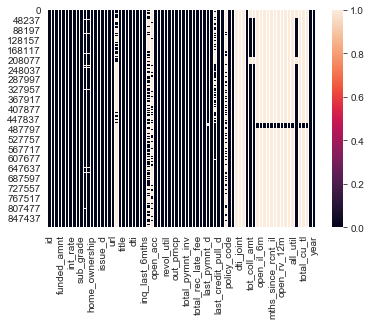

In [19]:
print(df.isnull().values.any())
sns.heatmap(df.isnull()) 

In [20]:
def null_values(df, perct_to_remove = 100):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        columns_to_remove = mis_val_table_ren_columns[mis_val_table_ren_columns['% of Total Values'] > perct_to_remove].index
        columns_to_keep = df.iloc[:,~df.columns.isin(columns_to_remove)].columns
        return mis_val_table_ren_columns , columns_to_keep 

In [21]:
cols_missing_values, col_to_keep = null_values(df , 10)

Dataframe has 76 columns.
There are 31 columns that have missing values.


In [22]:
df = df[col_to_keep]
nullCount = df.isnull().sum()
nullCount[nullCount>0]

emp_title             51016
emp_length            44825
title                   150
revol_util              442
last_pymnt_d          17640
last_credit_pull_d       50
tot_coll_amt          61999
tot_cur_bal           61999
total_rev_hi_lim      61999
dtype: int64

Text(0, 0.5, 'Data type')

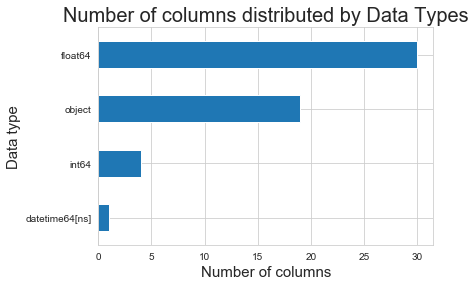

In [23]:
# Number of each type of column
df.dtypes.value_counts().sort_values().plot(kind='barh')
plt.title('Number of columns distributed by Data Types',fontsize=20)
plt.xlabel('Number of columns',fontsize=15)
plt.ylabel('Data type',fontsize=15)

## Removing Columns that have more than 10 categories

In [24]:
## Helper function to easily get columns with specific data type
def get_specific_columns(df, data_types, to_ignore = list(), ignore_target = False):
    columns = df.select_dtypes(include=data_types).columns
    if ignore_target:
        columns = filter(lambda x: x not in to_ignore, list(columns))
    return columns

In [25]:
## Save all columns with 'object' datatype (non-numerical)
obj_variables = get_specific_columns(df, ['object'], ['TARGET'], ignore_target = True)
obj = df[list(obj_variables)]

In [26]:
not_to_much_unique = df.loc[:,~df.columns.isin(obj.loc[:,obj.nunique() > 10].columns)].columns

In [27]:
df = df[not_to_much_unique]

In [28]:
 ### why are we doing this?

In [29]:
df.drop(['collections_12_mths_ex_med' , 'tot_coll_amt' ,'id', 'loan_status' ] , axis = 1 , inplace = True)

## Impute missing values

In [30]:
nullCount = df.isnull().sum()
nullCount[nullCount>0]

revol_util            442
tot_cur_bal         61999
total_rev_hi_lim    61999
dtype: int64

In [31]:
#### since 5 columns have the same nulls we decided to drop these 29 rows 
df = df.loc[~df[ 'delinq_2yrs' ].isnull()]

In [32]:
### here we use SimpleImputer form sklearn to impute NA, the strategy decided is median to not change the distribution since tehy are skewed
imp = SimpleImputer( strategy='median', verbose=1)
numericals = list(get_specific_columns(df, ['int64' , 'float64'], ['TARGET'], ignore_target = True))

num = df[numericals]

df[numericals] =imp.fit_transform(num) 

## Feature Engineering

In [33]:
# 1 
intrst_per_grade = df[['int_rate','grade']].groupby('grade').agg(['mean','std'])
dum = df[['grade','int_rate']].join(intrst_per_grade , on ='grade')
dum['intrst_per_grade'] = (dum['int_rate'] - dum[('int_rate', 'mean')]) / dum[('int_rate', 'std')]
df['intrst_per_grade']= dum['intrst_per_grade']

/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [34]:
# 2 %  last_paymnt_amnt / tot_cur_bal
df['perc_last_pay_from_bal'] = df['installment'] / (df['tot_cur_bal'] + 1)

In [35]:
# 3 [last_pay - ( tot_cur_bal + annual_income/12)] if positive  1(dsnt have wnough money to pay) if negative has 0 
df['not_engh_to_pay'] = df['installment'] - df['tot_cur_bal'] - df['annual_inc']/12
df['not_engh_to_pay'] = np.where(df['not_engh_to_pay'] > 0, 1, 0).astype('object')

## Scaling Numerical Values

In [36]:
scaler = StandardScaler()
numericals = list(get_specific_columns(df, ['int64' , 'float64'], ['TARGET' , 'member_id'], ignore_target = True))
num = df[numericals]

df[numericals] =scaler.fit_transform(num)

## Binnng

In [37]:
skt = KBinsDiscretizer(n_bins = 5 , strategy = 'quantile' , encode = 'ordinal')
to_bin = np.array(df['total_pymnt']).reshape(-1, 1)
df[['total_pymnt']] = skt.fit_transform(to_bin)
df[['total_pymnt']] = df[['total_pymnt']].astype('object' , inplace =True)

In [38]:
## whats this?

In [39]:
#### interest rate compared to ppl in ur grade 
#### %  last_paymnt_amnt / tot_cur_bal
####   [last_pay - ( tot_cur_bal + annual_income/12)] if positive  1(dsnt have wnough money to pay) if negative has 0 

## One Hot Encoding

In [40]:
def One_hot_sklearn(df , categoricals): 
    df.copy()
    for i in categoricals:
        print(i)
        hot = OneHotEncoder()
        X = hot.fit_transform(df[i].values.reshape(-1,1)).toarray()
        dfOneHot = pd.DataFrame(X, columns = [str(i)+str('_')+str(j[3:]) for j in hot.get_feature_names()])
        dfOneHot['member_id'] = df['member_id']
        df = df.merge(dfOneHot,on = 'member_id')
        df.drop(i, axis =1 , inplace = True)
    return df 

In [41]:
obj_variables = list(get_specific_columns(df, ['object'], ['TARGET'], ignore_target = True))
df = One_hot_sklearn(df , obj_variables)

term
grade
home_ownership
verification_status
pymnt_plan
initial_list_status
total_pymnt
application_type
not_engh_to_pay


In [42]:
df.head(10)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,issue_d,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,policy_code,acc_now_delinq,tot_cur_bal,total_rev_hi_lim,TARGET,...,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,pymnt_plan_n,pymnt_plan_y,initial_list_status_f,initial_list_status_w,total_pymnt_0.0,total_pymnt_1.0,total_pymnt_2.0,total_pymnt_3.0,total_pymnt_4.0,application_type_INDIVIDUAL,application_type_JOINT,not_engh_to_pay_0.0
0,1296599.0,-1.161871,-1.161323,-1.163337,-0.593041,-1.126090,-0.789511,2011-12-01,0.547268,-0.365318,0.322254,-1.611482,-0.3365,-0.146656,1.201827,-1.378405,-0.998625,-0.998625,-0.215544,-0.110894,-0.426335,-0.094817,-0.112277,-0.079444,-0.415439,0.0,-0.064567,-0.367432,-0.214783,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,1314167.0,-1.458103,-1.457773,-1.457012,0.458401,-1.547969,-0.696802,2011-12-01,-0.997690,-0.365318,4.426518,-1.611482,-0.3365,-0.682507,-1.925431,-1.801008,-0.998625,-0.998625,-0.829277,-0.796378,-0.629006,-0.094817,0.176714,-0.060760,-0.426250,0.0,-0.064567,-0.367432,-0.214783,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1313524.0,-1.469952,-1.469631,-1.468878,0.615434,-1.447659,-0.971034,2011-12-01,-0.550145,-0.365318,1.348320,-1.799543,-0.3365,-0.625656,1.824753,-1.293885,-0.998625,-0.998625,-0.575422,-0.503156,-0.548832,-0.094817,-0.112277,-0.079444,-0.315926,0.0,-0.064567,-0.367432,-0.214783,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,1277178.0,-0.569408,-0.568422,-0.567089,0.053300,-0.403687,-0.400135,2011-12-01,0.103781,-0.365318,0.322254,-0.295053,-0.3365,-0.507295,-1.437191,0.988169,-0.998625,-0.998625,0.598155,0.643455,0.215256,4.193105,-0.112277,-0.079444,-0.376769,0.0,-0.064567,-0.367432,-0.214783,0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1311748.0,-1.398857,-1.398483,-1.397684,-0.128768,-1.515379,0.075769,2011-12-01,-0.015642,-0.365318,-0.703813,0.645252,-0.3365,0.486591,-0.052443,1.072690,-0.908337,-0.908301,-0.545070,-0.528336,-0.355906,-0.094817,-0.112277,-0.079444,-0.437042,0.0,-0.064567,-0.367432,-0.214783,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
5,1311441.0,-1.161871,-1.161323,-1.160371,-1.218899,-1.152335,-0.604094,2011-12-01,-0.406374,-0.365318,2.374386,-0.483115,-0.3365,-0.401343,-1.129937,-1.124844,-0.998625,-0.998625,-0.241045,-0.110894,-0.535636,-0.094817,-0.112277,-0.079444,-0.417642,0.0,-0.064567,-0.367432,-0.214783,0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
6,1304742.0,-0.924886,-0.924162,-0.923058,0.615434,-1.096570,-0.434066,2011-12-01,0.307263,-0.365318,0.322254,-0.859237,-0.3365,0.036038,1.281797,-1.209364,-0.776213,-0.776123,0.077773,-0.094170,0.603877,-0.094817,-0.112277,-0.079444,-0.415759,0.0,-0.064567,-0.367432,-0.214783,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
7,1288686.0,-1.398857,-1.398483,-1.397684,1.225361,-1.344891,-0.418677,2011-12-01,-0.745511,-0.365318,1.348320,-1.423420,-0.3365,-0.389785,1.361767,-1.801008,-0.998625,-0.998625,-0.456508,-0.412634,-0.389660,-0.094817,-0.112277,-0.079444,-0.427981

## Splitting Train and Test Set

In [81]:
X = df.loc[:,df.columns!='TARGET']
y = df['TARGET']

In [82]:
## change this to split based on dates

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=100)

## Over-Sampling 


In [106]:
Xy_train = X_train.copy()
Xy_train['TARGET'] = y_train

In [107]:
defaulted = Xy_train[ Xy_train.TARGET == 1]
not_defaulted = Xy_train[Xy_train.TARGET == 0]

In [108]:
defaulted_upsampled=resample(defaulted,
                          replace=True, # sample with replacement
                          n_samples=round(0.3*len(not_defaulted)), # match number in majority class
                          random_state=42) # reproducible results

In [109]:
upsampled = pd.concat([not_defaulted, defaulted_upsampled])

In [110]:
y_train = upsampled['TARGET']
X_train = upsampled.drop(['TARGET','member_id'], axis =1 )
X_test.drop('member_id', axis =1 , inplace = True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Modelling

#### Logistic Regression

In [137]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
anova_filter = SelectKBest(chi2, k=5)
clf = LogisticRegression()
anova_log = Pipeline([('anova', anova_filter), ('log', clf)])
anova_log.set_params(anova__k=10).fit(X_train, y_train)

ValueError: Input X must be non-negative.

In [136]:
f1_score(y_test, anova_log.predict(X_test))

0.6045630888601514

In [111]:
log = LogisticRegression()

In [112]:
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [113]:
predLog = log.predict(X_test)

In [114]:
accuracy_score(y_test, predLog)

0.9803462234088365

In [115]:
f1_score(y_test, predLog)

0.8382860112439174

#### Random Forest Regressor

In [116]:
rf = RandomForestClassifier()

In [117]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [118]:
predRF = rf.predict(X_test)

In [119]:
accuracy_score(y_test, predRF)

0.9817299687078346

In [120]:
f1_score(y_test, predRF)

0.8463247367912681

## Cross Validation and Hyperparameter Tuning

In [ ]:
## Perform grid search with multiple parameter options for Random Forest Classifier

In [ ]:
# Number of trees in random forest
n_estimators = [50, 100, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [100, 150]
# Minimum number of samples required to split a node
min_samples_split = [2, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
kfold = KFold(n_splits=3)

# grid_search = GridSearchCV(
#         estimator=RandomForestClassifier(),
#         param_grid=random_grid,
# #         scoring="accuracy",
#         scoring = make_scorer(f1_score)
#         cv=kfold,
#         refit=True,
#         n_jobs=-1,
#         verbose = 2,
# )

grid_search = RandomizedSearchCV(
        estimator=RandomForestClassifier(),
        param_distributions=random_grid,
#         scoring="accuracy",
        scoring = make_scorer(f1_score),
        cv=kfold,
        refit=True,
        random_state=999,
        n_iter = 1,
        n_jobs=-1,
        verbose = 2,
)

grid_result = grid_search.fit(X_test, y_test)

In [ ]:
print(
    "\tAverage result for best Random Forest: {} +/- {:.5f}".format(
        grid_result.best_score_,
        grid_result.cv_results_["std_test_score"][
            np.argmax(grid_result.cv_results_["mean_test_score"])
        ],
    )
)

In [ ]:
grid_result.best_params_

## Metrics

#### ROC Curve (Random Forest Regressor)

In [ ]:
logit_roc_auc = roc_auc_score(y_test, predRF)
print(logit_roc_auc)
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()  
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show();